<a href="https://colab.research.google.com/github/moumahan1990/AV_electricity_consumption_forecasting/blob/master/EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# loading packages
# basic + dates 
import numpy as np
import pandas as pd
from pandas import datetime

# data visualization
import matplotlib.pyplot as plt
import seaborn as sns # advanced vizs
sns.set_style('whitegrid')
%matplotlib inline
import plotly.express as px
import plotly.graph_objects as go

# machine learning
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
import xgboost as xgb

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
train  = pd.read_csv("https://raw.githubusercontent.com/moumahan1990/AV_electricity_consumption_forecasting/master/train.csv", 
                        parse_dates = True, index_col = 'datetime', low_memory=False)
test   = pd.read_csv("https://raw.githubusercontent.com/moumahan1990/AV_electricity_consumption_forecasting/master/test.csv", 
                        parse_dates = True, index_col = 'datetime', low_memory=False)

In [0]:
train['Year'] = train.index.year
train['Month'] = train.index.month
train['Day'] = train.index.day
train['WeekOfYear'] = train.index.weekofyear
train['Hour'] = train.index.hour
train['DayOfWeek'] = train.index.dayofweek

train['electricity_consumption'] = train['electricity_consumption'].apply(lambda x : int(x))
train['temperature'] = train['temperature'].apply(lambda x : round(x))
train['pressure'] = train['pressure'].apply(lambda x : int(x))
train['windspeed'] = train['windspeed'].apply(lambda x : round(x))
train['var1'] = train['var1'].apply(lambda x : round(x))

vars_replace = {"var2" : {"A":1,"B":2,"C":3}}
train.replace(vars_replace, inplace=True)

In [76]:
train.head()

,ID,temperature,var1,pressure,windspeed,var2,electricity_consumption,Year,Month,Day,WeekOfYear,Hour,DayOfWeek
datetime,,,,,,,,,,,,,
2013-07-01 00:00:00,0,-11,-17,1003,572,1,216,2013,7,1,27,0,0
2013-07-01 01:00:00,1,-12,-19,996,575,1,210,2013,7,1,27,1,0
2013-07-01 02:00:00,2,-13,-20,1000,578,1,225,2013,7,1,27,2,0
2013-07-01 03:00:00,3,-11,-17,995,583,1,216,2013,7,1,27,3,0
2013-07-01 04:00:00,4,-11,-19,1005,587,1,222,2013,7,1,27,4,0


# EDA

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



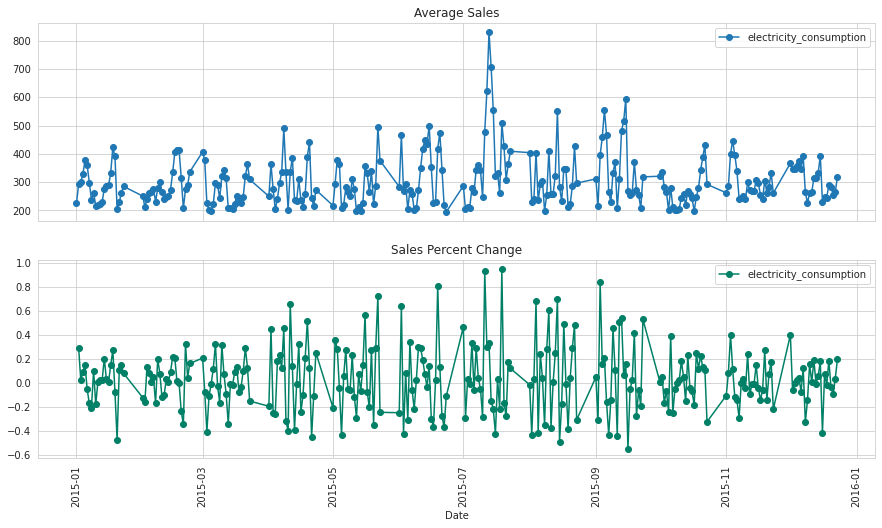

In [36]:
df = train[(train.index.year == 2015)]
df['Date'] = df.index.date
average_consumption    = df.groupby('Date')["electricity_consumption"].mean()
pct_change_sales = df.groupby('Date')["electricity_consumption"].sum().pct_change()

fig, (axis1,axis2) = plt.subplots(2,1,sharex=True,figsize=(15,8))

# plot average sales over time(year-month)
ax1 = average_consumption.plot(legend=True,ax=axis1,marker='o',title="Average Sales")
ax1.set_xticks(range(len(average_consumption)))
ax1.set_xticklabels(average_consumption.index.tolist(), rotation=90)
ax2 = pct_change_sales.plot(legend=True,ax=axis2,marker='o',rot=90,colormap="summer",title="Sales Percent Change")
# type(average_sales)

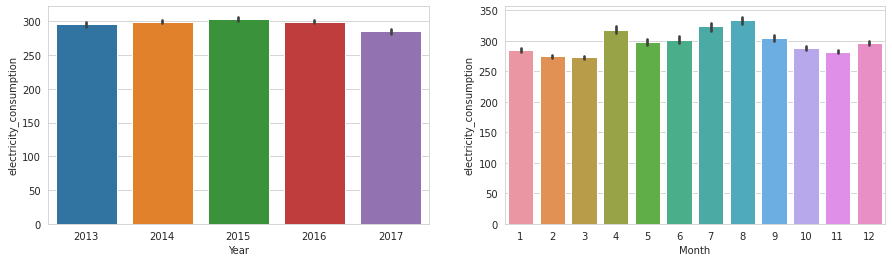

In [49]:
# Plot average sales & customers for every year
fig, (axis1,axis2) = plt.subplots(1,2,figsize=(15,4))

sns.barplot(x='Year', y='electricity_consumption', data=train, ax=axis1)
sns.barplot(x='Month', y='electricity_consumption', data=train, ax=axis2)

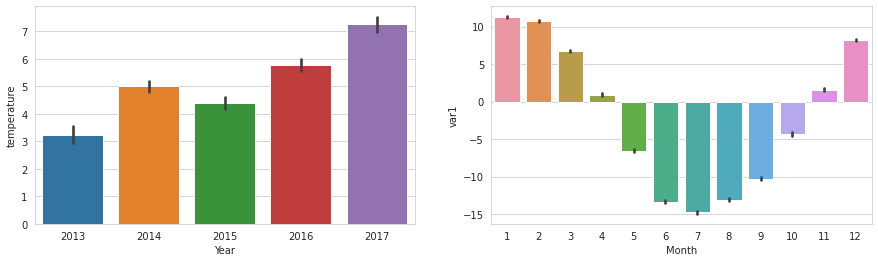

In [64]:
# Plot average sales & customers for every year
fig, (axis1,axis2) = plt.subplots(1,2,figsize=(15,4))

sns.barplot(x='Year', y='temperature', data=train, ax=axis1)
sns.barplot(x='Month', y='var1', data=train, ax=axis2)

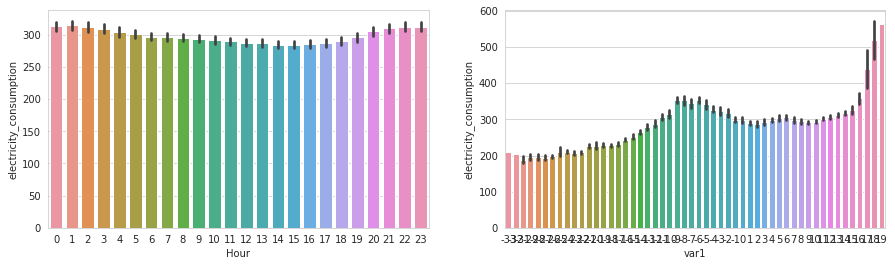

In [69]:
# DayOfWeek
# In both cases where the store is closed and opened

fig, (axis1,axis2) = plt.subplots(1,2,figsize=(15,4))

sns.barplot(x='Hour', y='electricity_consumption', data=train,  ax=axis1)
sns.barplot(x='var1', y='electricity_consumption', data=train,  ax=axis2)

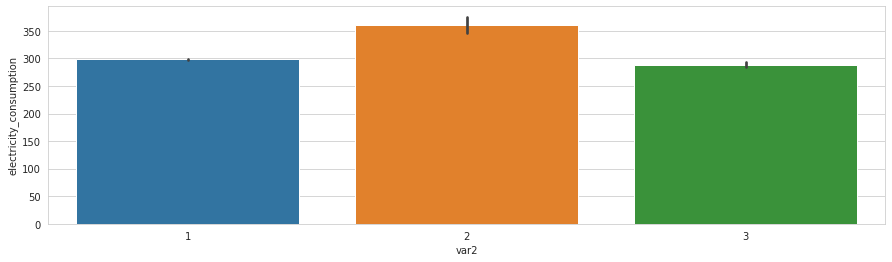

In [77]:
fig, (axis1) = plt.subplots(1,1,figsize=(15,4))

sns.barplot(x='var2', y='electricity_consumption', data=train,  ax=axis1)

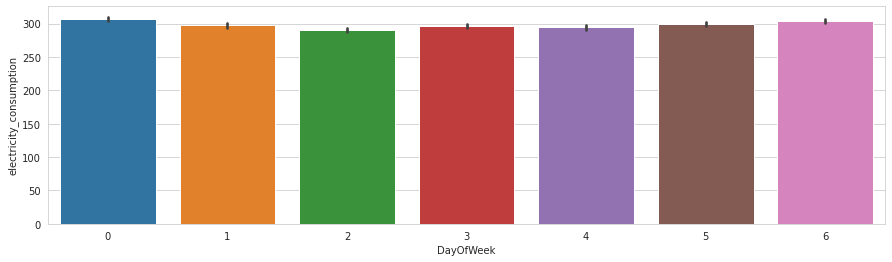

In [125]:
fig, (axis1) = plt.subplots(1,1,figsize=(15,4))

sns.barplot(x='DayOfWeek', y='electricity_consumption', data=train,  ax=axis1)

# Model

In [82]:
train[train['Year'] == 2013]['Month'].value_counts()

11    552
9     552
7     552
12    552
10    552
8     552
Name: Month, dtype: int64

In [0]:
sel_df = train[(train['Month'] == 7) & (train['Year'] == 2013)]

In [0]:
from sklearn import preprocessing
min_max_scaler = preprocessing.MinMaxScaler()
ec_scaled = min_max_scaler.fit_transform(sel_df[['electricity_consumption']])
sel_df['ec_scaled'] = ec_scaled
sel_df['windspeed_scaled'] = min_max_scaler.fit_transform(sel_df[['windspeed']])
sel_df['pressure_scaled'] = min_max_scaler.fit_transform(sel_df[['pressure']])
sel_df['temperature_scaled'] = min_max_scaler.fit_transform(sel_df[['temperature']])
sel_df['var1_scaled'] = min_max_scaler.fit_transform(sel_df[['var1']])

In [96]:
features = ['Month', 'Day', 'Year', 'WeekOfYear','DayOfWeek' , 'Hour', 'temperature_scaled', 'pressure_scaled', 'windspeed_scaled', 'var1_scaled', 'var2']
train_data_X = sel_df[features]
train_data_y = sel_df[['ec_scaled']]
print("Shape of data:",train_data_X.shape,train_data_y.shape)

Shape of data: (552, 11) (552, 1)


In [0]:
#Prepare train test split - 16 days for train, 7 days for validation
X_train = train_data_X.head(384)
X_test = train_data_X.tail(168)
y_train = train_data_y.head(384)
y_test = train_data_y.tail(168)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fbfa4b7ae80>]],
      dtype=object)

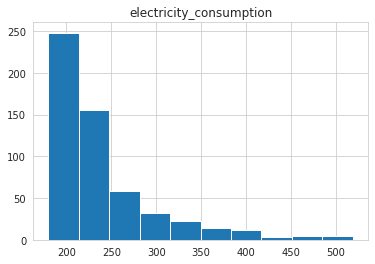

In [124]:
sel_df[['electricity_consumption']].hist()

In [109]:
from sklearn.ensemble import RandomForestRegressor

clf_RF = RandomForestRegressor(n_estimators = 15,max_depth = 10,criterion = "mse")
clf_RF.fit(X_train, y_train)
# validation
y_pred = clf_RF.predict(X_test)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



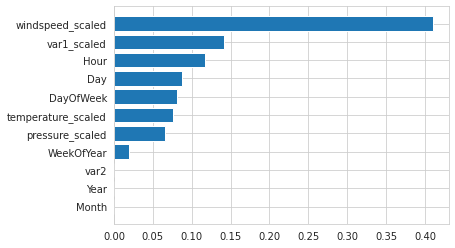

In [110]:

def plot_importance(model):
    k = list(zip(features, model.feature_importances_))
    k.sort(key=lambda tup: tup[1])

    labels, vals = zip(*k)
    
    plt.barh(np.arange(len(features)), vals, align='center')
    plt.yticks(np.arange(len(features)), labels)
plot_importance(clf_RF)

In [123]:
test = pd.DataFrame()
test['test'] = y_test.ec_scaled
test['pred'] = y_pred
test

,test,pred
datetime,,
2013-07-17 00:00:00,0.424779,0.070383
2013-07-17 01:00:00,0.433628,0.254867
2013-07-17 02:00:00,0.495575,0.119322
2013-07-17 03:00:00,0.194690,0.107694
2013-07-17 04:00:00,0.176991,0.096991
...,...,...
2013-07-23 19:00:00,0.106195,0.080105
2013-07-23 20:00:00,0.115044,0.083465
2013-07-23 21:00:00,0.061947,0.091177


In [115]:
#RMSE,MAPE,MAE
from math import sqrt
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

rmse_rf = sqrt(mean_squared_error(y_test, y_pred))
MAPE= np.mean(np.abs((y_test.ec_scaled- y_pred) / y_test.ec_scaled)) * 100
print("MAPE: ",MAPE)
print("MAE: ", mean_absolute_error(y_test.ec_scaled, y_pred))
print("RMSE: ",rmse_rf)

def MASE(training_series, testing_series, prediction_series):
    n = training_series.shape[0]
    d = np.abs(  np.diff( training_series) ).sum()/(n-1)
    
    errors = np.abs(testing_series - prediction_series )
    return errors.mean()/d
def smape(actual, predicted):
    # return 100/len(test) * np.sum(2 * np.abs(pred - test) / (np.abs(test) + np.abs(pred)))
    return np.mean(2.0 * np.abs(actual - predicted) / ((np.abs(actual) + np.abs(predicted))))

print("MASE",MASE(y_train.ec_scaled,y_test.ec_scaled,y_pred))
print("SMAPE",smape(y_test.ec_scaled,y_pred))

MAPE:  110.72336447286617
MAE:  0.09859791928412306
RMSE:  0.1500217345710665
MASE 1.9921658957504957
SMAPE 0.5594987413200327
